In [2]:
import pandas as pd
import os
import re

files = [*(os.scandir('csvs_plus'))]
csv_list = []
reg = r'(\d*)_data.csv'

data_dict = {}
for f in files:
    station = re.findall(reg, f.name)[0]
    data_dict[station] = pd.read_csv(f'csvs_plus/{f.name}',
                                     index_col=0,
                                     parse_dates=['날짜'],
                                     infer_datetime_format=True)
    # data_dict[station] = data_dict[station].loc[data_dict[station]['대여량'] > 0]
    
save = [9, 10, 11]
def save_ds_from_array(l: pd.Series) -> pd.Series:
    c = l.copy()
    for i, v in c.items():
        if v.month in save:
            c[i] = True
        else:
            c[i] = False
    return c
data_filtered_dict = {}
for st, dfs in data_dict.items():
    data_filtered_dict[st] = dfs.loc[save_ds_from_array(dfs['날짜'])]
data_filtered_dict[st]

,날짜,요일,am/pm,시간대,대여량,강수량,기온,풍속
912,2022-09-01,3,0,0,0,0.0,22.4,1.4
913,2022-09-01,3,0,1,0,0.0,22.4,1.4
914,2022-09-01,3,0,2,0,0.0,22.4,1.4
915,2022-09-01,3,0,3,0,0.0,22.4,1.4
916,2022-09-01,3,0,4,0,0.0,22.4,1.4
...,...,...,...,...,...,...,...,...
3091,2022-11-30,2,1,7,5,0.0,-2.9,3.7
3092,2022-11-30,2,1,8,3,0.0,-2.9,3.7
3093,2022-11-30,2,1,9,0,0.0,-2.9,3.7
3094,2022-11-30,2,1,10,3,0.0,-2.9,3.7


In [3]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from utils import Convert2EncodedDF

xgb_models = {}
rf_models = {}
## Training XGBRegressor
for st, df in data_filtered_dict.items():
    model_xg = XGBRegressor()
    model_rf = RandomForestRegressor()
    x = df.drop(columns=['대여량', '날짜'])
    # x = Convert2EncodeDF(x, ['
    y = df['대여량']
    model_xg.fit(x, y)
    model_rf.fit(x, y)
    xgb_models[st] = model_xg
    rf_models[st] = model_rf
rf_models

{'194': RandomForestRegressor(),
 '768': RandomForestRegressor(),
 '1021': RandomForestRegressor(),
 '764': RandomForestRegressor(),
 '198': RandomForestRegressor(),
 '1020': RandomForestRegressor(),
 '1015': RandomForestRegressor(),
 '892': RandomForestRegressor(),
 '1084': RandomForestRegressor(),
 '368': RandomForestRegressor(),
 '886': RandomForestRegressor(),
 '765': RandomForestRegressor(),
 '1016': RandomForestRegressor(),
 '766': RandomForestRegressor(),
 '1018': RandomForestRegressor(),
 '763': RandomForestRegressor(),
 '1017': RandomForestRegressor(),
 '191': RandomForestRegressor(),
 '366': RandomForestRegressor(),
 '1023': RandomForestRegressor(),
 '199': RandomForestRegressor(),
 '85': RandomForestRegressor(),
 '404': RandomForestRegressor(),
 '1051': RandomForestRegressor(),
 '195': RandomForestRegressor(),
 '193': RandomForestRegressor(),
 '192': RandomForestRegressor(),
 '1052': RandomForestRegressor(),
 '1085': RandomForestRegressor(),
 '406': RandomForestRegressor()}

       요일  am/pm   시간대  강수량    기온   풍속
845   2.0    0.0   5.0  0.0  20.9  1.3
1865  2.0    1.0   5.0  0.0   9.2  1.4
1786  6.0    0.0  10.0  0.0  17.7  1.4
1926  5.0    0.0   6.0  0.0  14.4  1.4
2249  4.0    1.0   5.0  0.0   5.9  2.4
...   ...    ...   ...  ...   ...  ...
2152  0.0    1.0   4.0  0.0  14.1  1.7
1659  1.0    0.0   3.0  0.0  12.0  2.0
1007  1.0    1.0  11.0  0.0  24.5  2.1
885   3.0    1.0   9.0  0.0  22.0  1.2
1983  0.0    1.0   3.0  0.0   9.7  1.9

[70 rows x 6 columns]


/tmp/ipykernel_532/1576491354.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


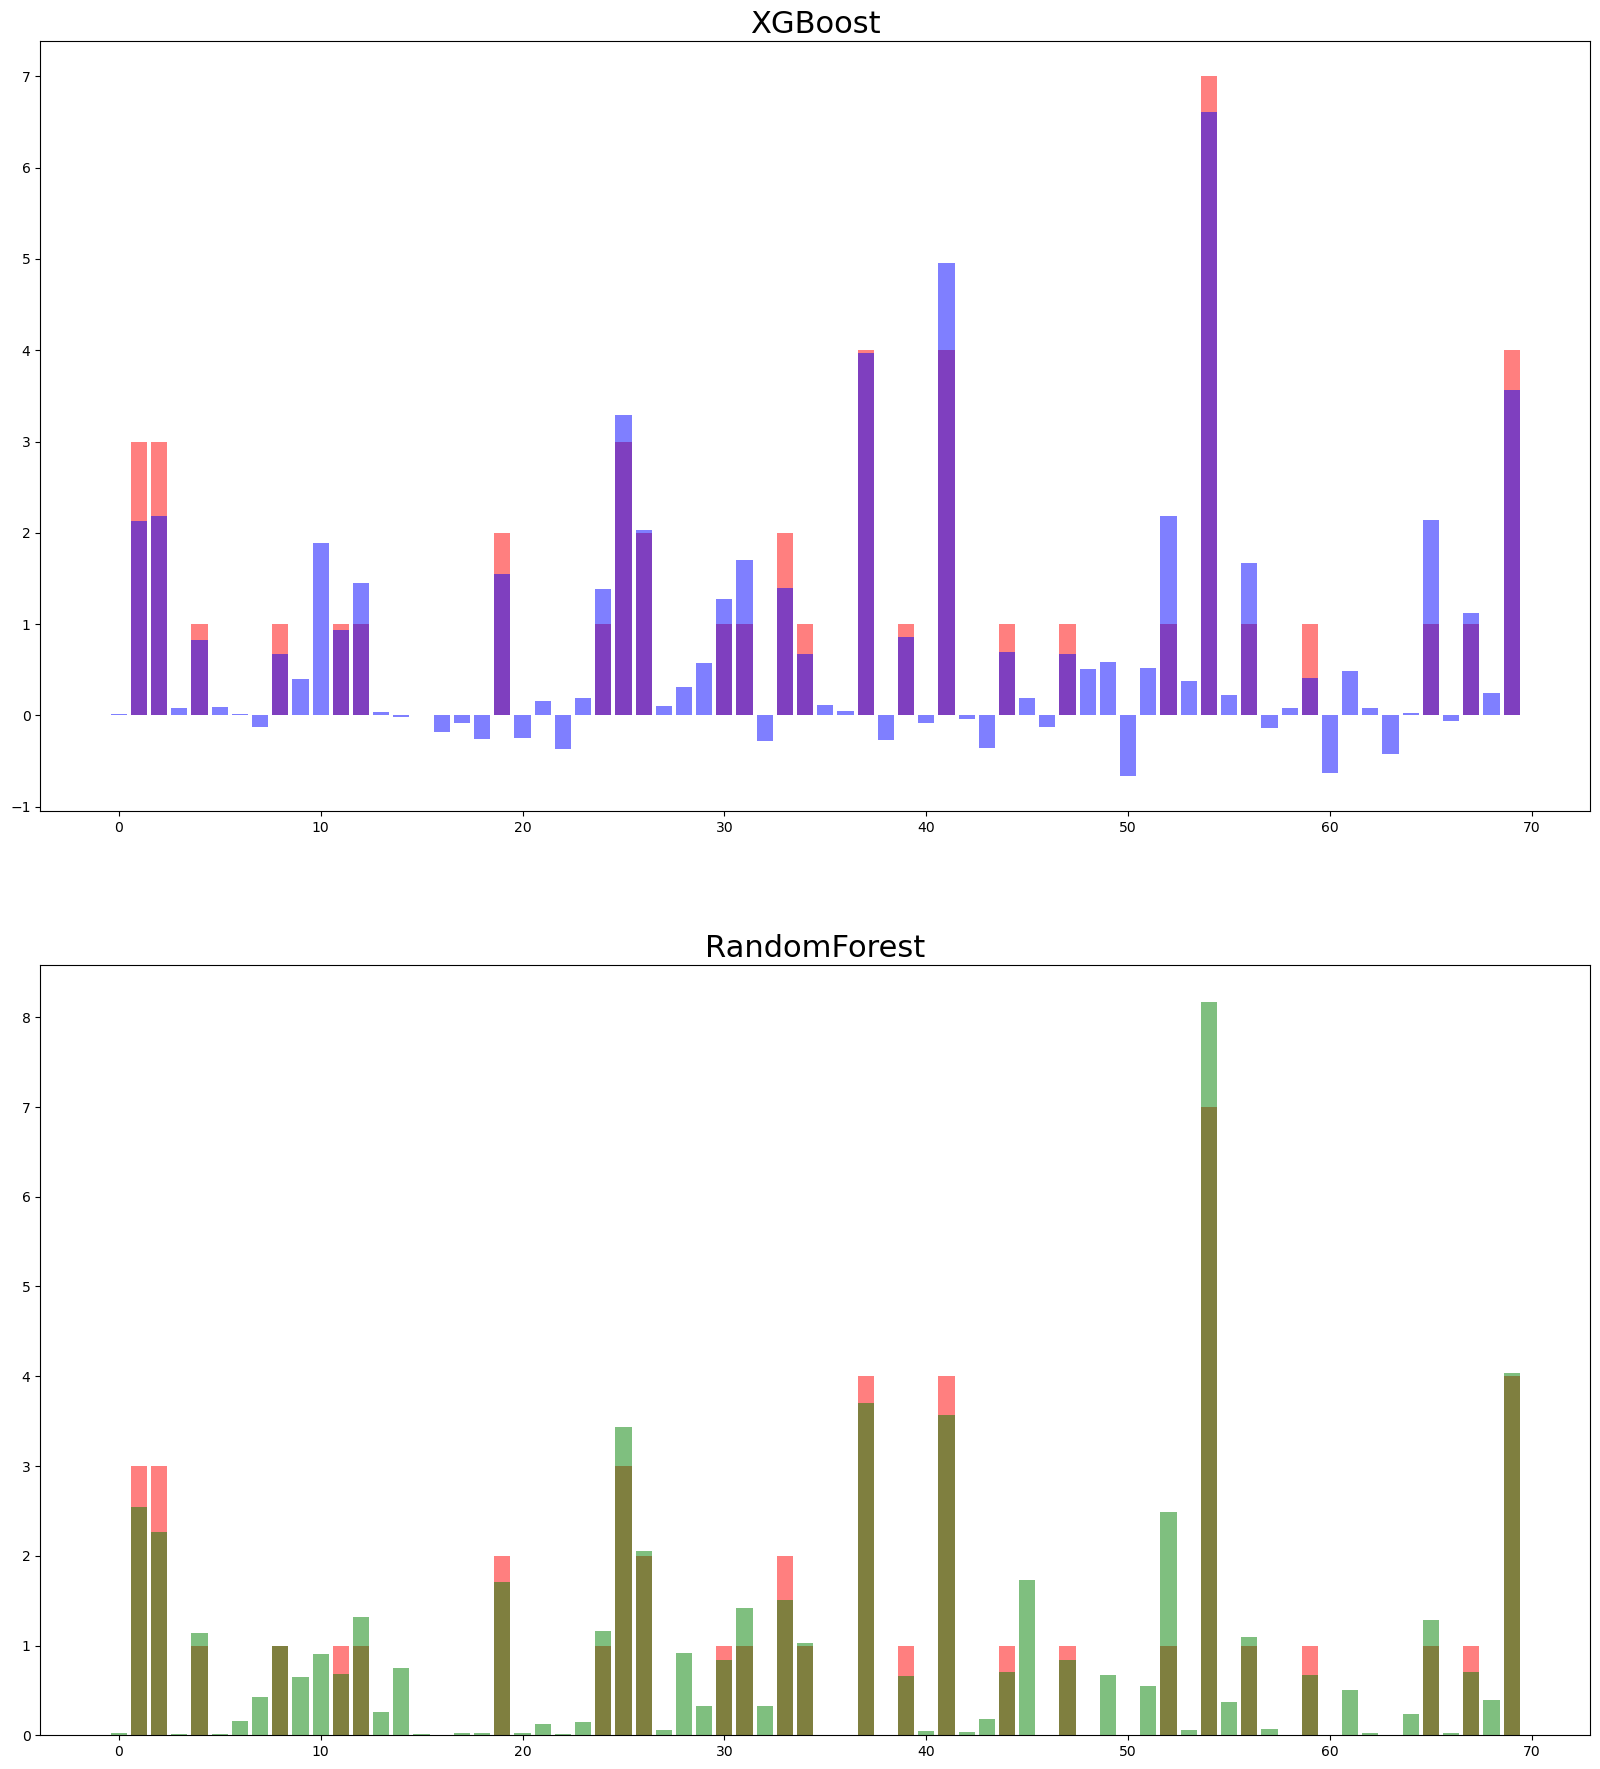

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random
station = '1016'
RAND_RANGE = 70

m = xgb_models[station]
x_val = data_filtered_dict[station].drop(columns=['날짜', '대여량'])
y_val = data_filtered_dict[station]['대여량']

randpick = [random.randint(0, len(x_val)-1) for r in range(RAND_RANGE)]

x_val_rand = [x_val.iloc[r] for r in randpick]
y_val_rand = [y_val.iloc[r] for r in randpick]
x_val_rand = pd.DataFrame(x_val_rand)
print(x_val_rand)
y_hat_xgb = m.predict(x_val_rand)
fig, ax = plt.subplots(2, 1, figsize=(20,22))
x_plot = np.arange(x_val_rand.shape[0])
ax[0].bar(x_plot, y_val_rand, color='red', alpha=0.5)
ax[0].bar(x_plot, y_hat_xgb, color='blue', alpha=0.5)
ax[0].set_title('XGBoost', fontsize=22)

m = rf_models[station]
y_hat_rf = m.predict(x_val_rand)
ax[1].bar(x_plot, y_val_rand, color='red', alpha=0.5)
ax[1].bar(x_plot, y_hat_rf, color='green', alpha=0.5)
ax[1].set_title('RandomForest', fontsize=22)
fig.show()

In [5]:
from sklearn.metrics import r2_score, mean_squared_error

m_xgb = xgb_models[station]
m_rf = rf_models[station]
y_hat_xgb = m_xgb.predict(x_val)
y_hat_rf = m_rf.predict(x_val)

xgb_r2 = r2_score(y_val, y_hat_xgb)
rf_r2 = r2_score(y_val, y_hat_rf)
xgb_mse = mean_squared_error(y_val, y_hat_xgb)
rf_mse = mean_squared_error(y_val, y_hat_rf)
xgb_r2, rf_r2, xgb_mse, rf_mse

(0.9573592796037074,
 0.9496764479954485,
 0.49998509429062127,
 0.5900703754578753)

/tmp/ipykernel_532/1973793620.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


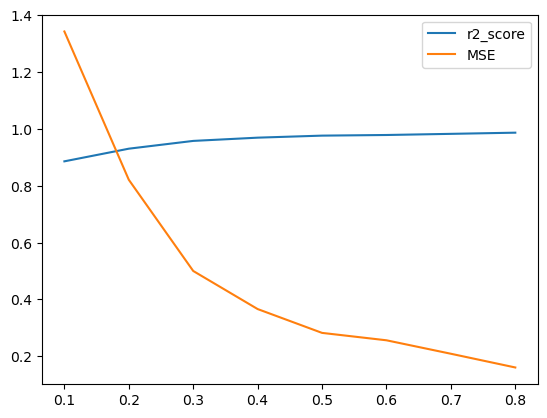

In [6]:
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

target_station = '1016'
valid_station = '1016'
# target_station = '366'
# valid_station = '368'
use_metrics = {
    'r2_score': r2_score,
    'MSE': mean_squared_error
}
metrics = [[] for i in range(len(use_metrics.keys()))]
x_range = np.arange(0.1, 0.9, 0.1)
x_t = data_filtered_dict[target_station].drop(columns=['날짜', '대여량'])
y_t = data_filtered_dict[target_station]['대여량']
x_v = data_filtered_dict[valid_station].drop(columns=['날짜', '대여량'])
y_v = data_filtered_dict[valid_station]['대여량']
for eta in x_range:
    model = XGBRegressor(eta=eta)
    model.fit(x_t, y_t)
    y_h = model.predict(x_v)
    for i, (k, m) in enumerate(use_metrics.items()):
        metrics[i].append(m(y_v, y_h))

fig, ax = plt.subplots()
for i, metrics_sublist in enumerate(metrics):
    ax.plot(x_range, metrics_sublist, label=list(use_metrics.keys())[i])
ax.legend()
fig.show()

/tmp/ipykernel_532/3244150054.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


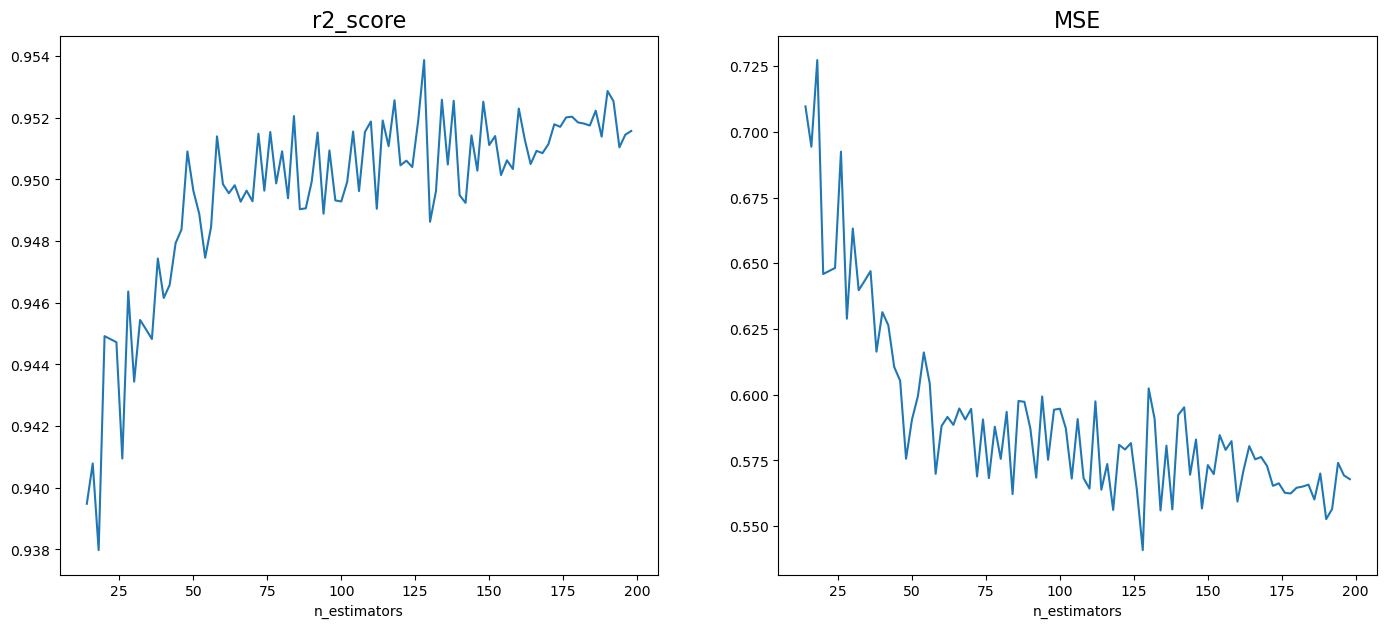

In [7]:
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

target_station = '1016'
valid_station = '1016'
# target_station = '366'
# valid_station = '368'
use_metrics = {
    'r2_score': r2_score,
    'MSE': mean_squared_error
}
metrics = [[] for i in range(len(use_metrics.keys()))]

x_range = np.arange(14, 200, 2)

x_t = data_filtered_dict[target_station].drop(columns=['날짜', '대여량'])
y_t = data_filtered_dict[target_station]['대여량']
x_v = data_filtered_dict[valid_station].drop(columns=['날짜', '대여량'])
y_v = data_filtered_dict[valid_station]['대여량']
for eta in x_range:
    model = RandomForestRegressor(n_estimators=eta)
    model.fit(x_t, y_t)
    y_h = model.predict(x_v)
    for i, (k, m) in enumerate(use_metrics.items()):
        metrics[i].append(m(y_v, y_h))

fig, ax = plt.subplots(1, len(use_metrics), figsize=(17, 7))
for i, metrics_sublist in enumerate(metrics):
    l = list(use_metrics.keys())[i]
    ax[i].plot(x_range, metrics_sublist, label=l)
    ax[i].set_title(l, fontsize=16)
    ax[i].set_xlabel('n_estimators')
fig.show()

r2_score: [0.6488097118716246, 0.669364910809237, 0.6567214654798612, 0.7173604033237243, 0.5508314926578404, 0.5893508291008831, 0.7248600884460608, 0.6262978371433934, 0.6341429852673687, 0.49908258505268943]
MSE: [3.0262657534246578, 4.356240182648402, 3.565441552511415, 4.591477625570776, 5.33705642201835, 5.2672729357798165, 3.2283839449541287, 4.902705963302752, 3.91067614678899, 3.9929201834862385]


/tmp/ipykernel_532/1784725093.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


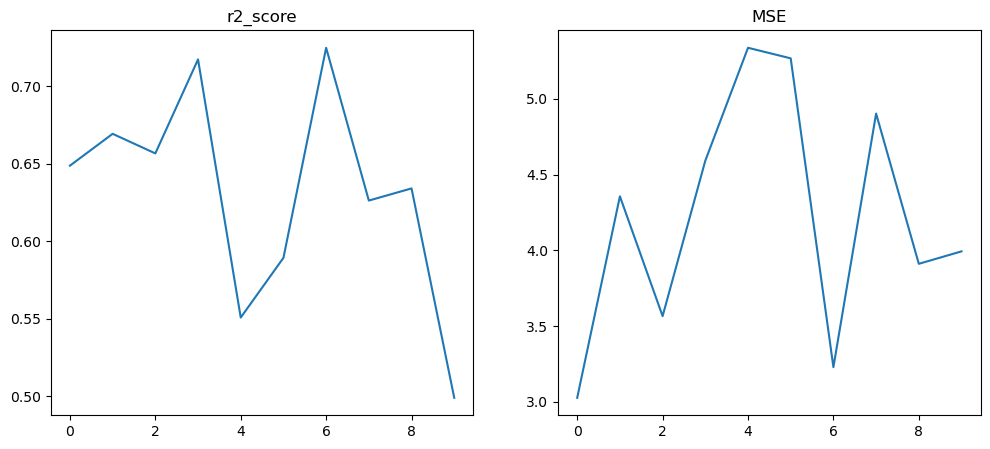

In [18]:
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

target_station = '1016'
valid_station = '1016'
# target_station = '366'
# valid_station = '368'
use_metrics = {
    'r2_score': r2_score,
    'MSE': mean_squared_error
}
K_RANGE = 10
kf = KFold(n_splits=K_RANGE, shuffle=True)
metrics = [[] for i in range(len(use_metrics.keys()))]

x_range = np.arange(14, 200, 2)

x_t = data_filtered_dict[target_station].drop(columns=['날짜', '대여량'])
y_t = data_filtered_dict[target_station]['대여량']
x_v = data_filtered_dict[valid_station].drop(columns=['날짜', '대여량'])
y_v = data_filtered_dict[valid_station]['대여량']
for train_index, test_index in kf.split(x_t):
    x_train, x_test = x_t.iloc[train_index], x_t.iloc[test_index]
    y_train, y_test = y_t.iloc[train_index], y_t.iloc[test_index]

    model = RandomForestRegressor()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    for i, (k, m) in enumerate(use_metrics.items()):
        metrics[i].append(m(y_test, y_pred))
for i, (method, _) in enumerate(use_metrics.items()):
    print(f'{method}: {metrics[i]}')
# for eta in x_range:
#     model = RandomForestRegressor(n_estimators=eta)
#     model.fit(x_t, y_t)
#     y_h = model.predict(x_v)
#     for i, (k, m) in enumerate(use_metrics.items()):
#         metrics[i].append(m(y_v, y_h))
fig, ax = plt.subplots(1, 2, figsize=(12,5))
r = np.arange(K_RANGE)
ax[0].plot(r, metrics[0], label='r2_score')
ax[0].set_title('r2_score')
ax[1].plot(r, metrics[1], label='MSE')
ax[1].set_title('MSE')
fig.show()
# fig, ax = plt.subplots(1, len(use_metrics))
# for i, metrics_sublist in enumerate(metrics):
#     l = list(use_metrics.keys())[i]
#     ax.plot(np.arange(k), metrics_sublist, label=l)
#     ax.set_title(l, fontsize=16)
#     ax.set_ylabel('n_estimators')
# fig.show()